# Chapter 6: Demo TimeSeries RNN LSTM
## Air Pollution Forecasting
We can use this data and frame a forecasting problem where, given the pollution for prior hours, we forecast the pollution at the next hour.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\ Drive/LDS8_K275_ONLINE_NGUYENTHIKIMHOANG/Week_4/Chapter6

/content/drive/MyDrive/Dethi


In [ ]:
# LSTM for air pollution problem with regression framing
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
    #t
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    #t+1
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
# load the dataset
dataframe = pd.read_csv('data/pollution_new.csv', index_col= 0)
dataframe.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
1/2/2010 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1/2/2010 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
1/2/2010 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
1/2/2010 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
1/2/2010 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
dataset = dataframe[["pollution"]]
dataset = dataset.values.astype('float32')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = 365 * 24 * 4 # vì dữ liệu theo giờ (lấy 4 năm đầu train)
#train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
type(trainX)

numpy.ndarray

In [ ]:
print(trainX[:5])

[[0.12977867]
 [0.14889336]
 [0.15995975]
 [0.18209255]
 [0.13883299]]


In [ ]:
print(trainY[:5])

[0.14889336 0.15995975 0.18209255 0.13883299 0.10965794]


In [ ]:
print(testX[:5])
print(testY[:5])

[[0.02414487]
 [0.05331992]
 [0.06539235]
 [0.07042253]
 [0.07947686]]
[0.05331992 0.06539235 0.07042253 0.07947686 0.09255533]


In [ ]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back))) # 64, ...
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY,
                    validation_data=(testX, testY),
                    epochs=50, #100, 200
                    batch_size=128, # 32, 64, 128
                    #callbacks=[early_stopping],
)

Epoch 1/50
274/274 [==============================] - 4s 5ms/step - loss: 0.0040 - val_loss: 7.1543e-04
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 8.1878e-04 - val_loss: 6.1197e-04
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 8.0834e-04 - val_loss: 6.0523e-04
Epoch 4/50
274/274 [==============================] - 1s 4ms/step - loss: 8.0686e-04 - val_loss: 6.1115e-04
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 8.0312e-04 - val_loss: 6.0292e-04
Epoch 6/50
274/274 [==============================] - 1s 3ms/step - loss: 8.0068e-04 - val_loss: 6.0554e-04
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 7.9921e-04 - val_loss: 6.0001e-04
Epoch 8/50
274/274 [==============================] - 1s 3ms/step - loss: 7.9985e-04 - val_loss: 5.9908e-04
Epoch 9/50
274/274 [==============================] - 1s 3ms/step - loss: 7.9551e-04 - val_loss: 5.9936e-04
Epoch 10/50
274/274 [===========

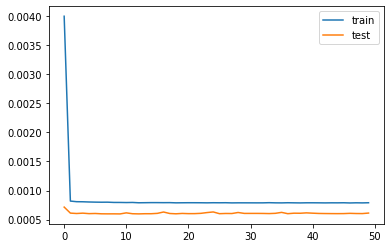

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [ ]:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainY[0][:5]

array([148.00000139, 158.99999549, 180.9999985 , 137.99999329,
       108.99999942])

In [ ]:
trainPredict[:5]

array([[125.90121],
       [144.26073],
       [154.85237],
       [175.95045],
       [134.60791]], dtype=float32)

In [ ]:
# calculate root mean squared error
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f RMSE' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f RMSE' % (test_rmse))

Train RMSE: 27.98 RMSE
Test RMSE: 24.60 RMSE


In [ ]:
train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f MAE' % (train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('test MAE: %.2f MAE' % (test_mae))

Train MAE: 13.84 MAE
test MAE: 13.00 MAE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

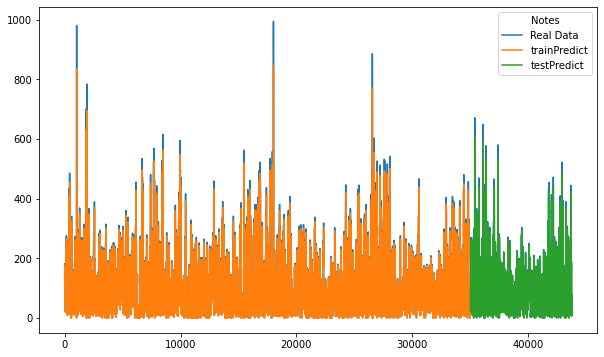

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()

In [ ]:
# x_new = 8 => next time = ?
x_new = scaler.transform([[8]])
x_new = numpy.reshape(x_new, (1, 1, 1))

In [ ]:
y_new = model.predict(x_new)
y_new = scaler.inverse_transform(y_new)
y_new

array([[7.236131]], dtype=float32)